In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl


In [84]:
#Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.0002
dropout_rate = 0.3

disc_input_size = 784 # size of input to discriminator
disc_output_size  = 1 # size of discriminator output
disc_hidden_size = 32 # size of hidden layer for discriminator

latent_size = 100 # size of latent vector to generator 
gen_output_size = 784 # size of generator output
gen_hidden_size = 32 # size of hidden layer for generator



In [85]:
class Generator(nn.Module):

    def __init__(self, latent_size, gen_hidden_size, gen_output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(latent_size, gen_hidden_size)
        self.fc2 = nn.Linear(gen_hidden_size, gen_hidden_size*2)
        self.fc3 = nn.Linear(gen_hidden_size*2, gen_hidden_size*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(gen_hidden_size*4, gen_output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final output layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

In [86]:
class Discriminator(nn.Module):

    def __init__(self, disc_input_size, disc_hidden_size, disc_output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(disc_input_size, disc_hidden_size*4)
        self.fc2 = nn.Linear(disc_hidden_size*4, disc_hidden_size*2)
        self.fc3 = nn.Linear(disc_hidden_size*2, disc_hidden_size)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(disc_hidden_size, disc_output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(dropout_rate)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # output final layer
        out = self.fc4(x)

        return out

In [87]:
# instantiating generator and discriminator
G = Generator(latent_size, gen_hidden_size, gen_output_size)
D = Discriminator(disc_input_size, disc_hidden_size, disc_output_size)


# printing values of generator and discriminator
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [88]:
def get_mnist_data():
  # convertint data to torch.FloatTensor
  transform = transforms.ToTensor()

  # get the training datasets
  return datasets.MNIST(root='data', train=True, download=True, transform=transform)  
  

In [89]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1    
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [90]:
# Create optimizers for the generator and discriminator 
gen_optimizer = optim.Adam(G.parameters(), learning_rate)
disc_optimizer = optim.Adam(D.parameters(), learning_rate)


In [91]:
# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 1000

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, latent_size))
fixed_z = torch.from_numpy(fixed_z).float()

#prepare the data loader
train_loader = torch.utils.data.DataLoader(get_mnist_data(), batch_size=batch_size)
# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        #TRAINING DISCRIMINATOR
        
        disc_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, latent_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        disc_optimizer.step()
        
        
        # TRAINING GENERATOR
        gen_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, latent_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        gen_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3948 | g_loss: 0.7649
Epoch [    2/  100] | d_loss: 0.4252 | g_loss: 3.3435
Epoch [    3/  100] | d_loss: 0.8030 | g_loss: 1.9551
Epoch [    4/  100] | d_loss: 0.5062 | g_loss: 4.7400
Epoch [    5/  100] | d_loss: 0.6160 | g_loss: 5.3208
Epoch [    6/  100] | d_loss: 0.8085 | g_loss: 3.5735
Epoch [    7/  100] | d_loss: 0.7089 | g_loss: 3.1041
Epoch [    8/  100] | d_loss: 0.7111 | g_loss: 3.3499
Epoch [    9/  100] | d_loss: 0.7018 | g_loss: 2.8817
Epoch [   10/  100] | d_loss: 0.8939 | g_loss: 2.7402
Epoch [   11/  100] | d_loss: 1.1615 | g_loss: 2.9994
Epoch [   12/  100] | d_loss: 0.8573 | g_loss: 2.6072
Epoch [   13/  100] | d_loss: 0.9719 | g_loss: 1.7510
Epoch [   14/  100] | d_loss: 0.9753 | g_loss: 2.5314
Epoch [   15/  100] | d_loss: 0.8965 | g_loss: 2.8335
Epoch [   16/  100] | d_loss: 0.9622 | g_loss: 2.4264
Epoch [   17/  100] | d_loss: 1.0212 | g_loss: 1.6061
Epoch [   18/  100] | d_loss: 0.9694 | g_loss: 1.9328
Epoch [   19/  100] | d_loss

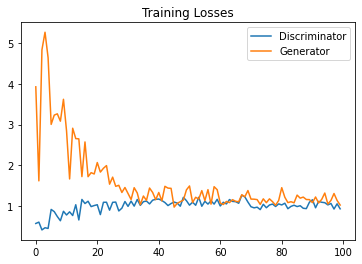

In [92]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [93]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

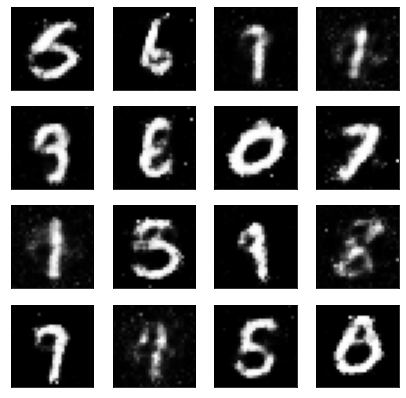

In [94]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)    

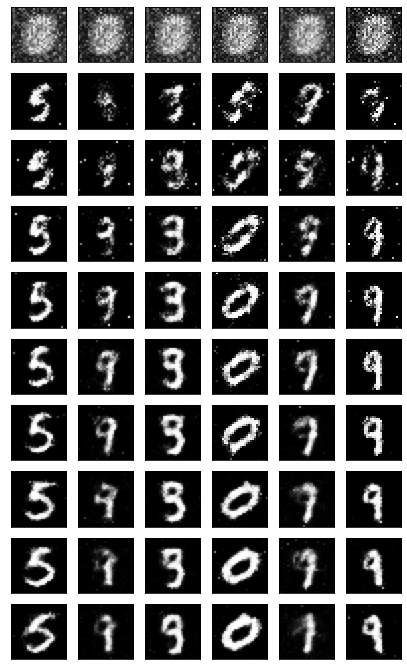

In [95]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)